# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии попытается определить приблизительный возраст человека. В датасете набор фотографий людей
с указанием возраста.

**Цели:**
* Провести исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
sns.set()

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import warnings
warnings.filterwarnings('ignore')

*Загрузим данные из файла csv и создадим датаФрейм labels, выведем первые 10 строчек датафрейма labels на экран.*

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
# выведем основную информацию о датафрейме.
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
print('Размер выборки', labels.shape)

Размер выборки (7591, 2)


<div class="alert" style="background-color:#ead7f7;color:#8737bf">

Для более качественной работы модели данных не достаточно.    
Имеет место смещенное распределение возраста. Модель хорошо обучится на возрасте примерно до 70 лет. Более подробно это можно посмотреть на boxplot. После этого возраста будут большие значения ошибки.

</div>

*Построим гистограмму распределения возраста в датафрейме.*

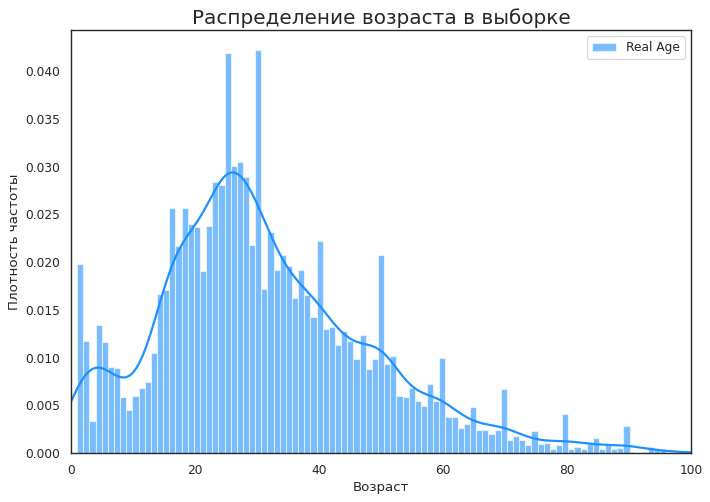

In [ ]:
sns.set_style("white")

x1 =  labels['real_age']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Real Age", **kwargs, bins=100)
plt.xlim(0,100)
plt.legend()
plt.title('Распределение возраста в выборке', fontdict={'fontsize': 18})
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Плотность частоты', fontsize=12);

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


*В датафрейме присутствуют данные по возрасту от 1 до 100 лет. Среднее значение 31 год.*
*Распределение смещено вправо.*
*Есть отдельные пики на круглых датах. Скорее всего имело место округления возраста.*

In [ ]:
# Масштабирование изображений
datagen = ImageDataGenerator(rescale=1./255)

# Создание генератора изображения
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


*Напечатаем на экране 16 фотографий*

In [ ]:
features, target = next(datagen_flow)

*Посмотрим размер изображений.*

In [ ]:
features.shape

(32, 224, 224, 3)

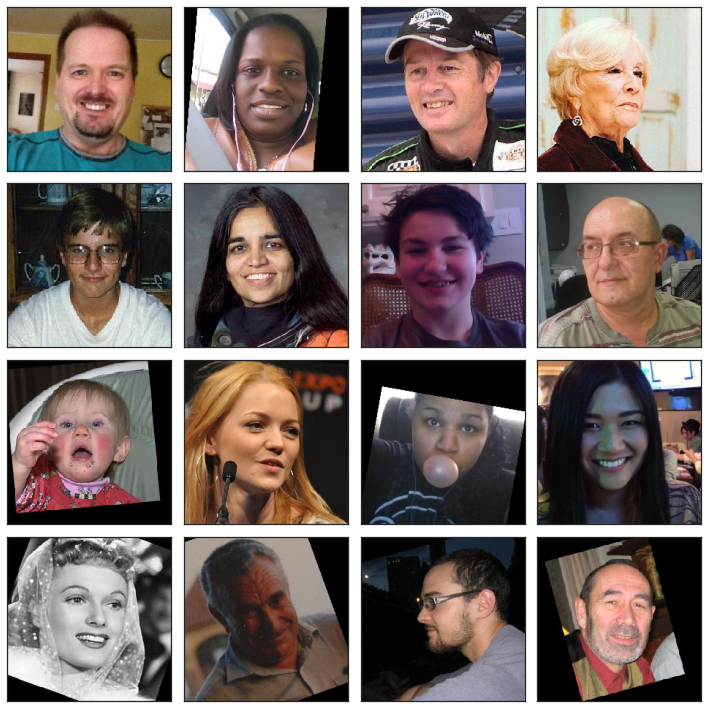

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    # удаляем оси и компануем изображения
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**
* В датафрейме 7591 фотография.
* Фотграфии сделаны с разным освещением, на разных не однотонных фонах, есть посторонние предметы и темный фон по краям.
* Не на всех фото четкие лица, есть фото в очках или прикрытые, а также черно-белые фото.
* Размер изображений (244 х 244), три канала.

## Обучение модели

Обучим модель в GPU-тренажёре и сохраните результат вывода модели на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


optimizer = Adam(lr=0.0001)

def load_train(path):
    train_data=pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                    dataframe=train_data,
                                    directory=path + '/final_files',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='training',
                                    seed=12345)  
    return train_datagen_flow

def load_test(path):
    test_data=pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow = validation_datagen.flow_from_dataframe(
                                    dataframe=test_data,
                                    directory=path + '/final_files',
                                    x_col='file_name',
                                    y_col='real_age',
                                    target_size=(224, 224),
                                    batch_size=32,
                                    class_mode='raw',
                                    subset='validation',
                                    seed=12345)
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)


    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)  

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
2023-04-06 10:34:06.313066: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-06 10:34:06.808073: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 71s - loss: 231.7690 - mae: 10.9855 - val_loss: 740.8537 - val_mae: 22.2816
Epoch 2/5
178/178 - 54s - loss: 61.1585 - mae: 5.9220 - val_loss: 659.6222 - val_mae: 20.4417
Epoch 3/5
178/178 - 53s - loss: 30.4105 - mae: 4.2466 - val_loss: 199.5489 - val_mae: 11.2172
Epoch 4/5
178/178 - 52s - loss: 19.7485 - mae: 3.4177 - val_loss: 102.1676 - val_mae: 7.7830
Epoch 5/5
178/178 - 51s - loss: 14.6466 - mae: 2.9445 - val_loss: 98.2758 - val_mae: 7.4597
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 98.2758 - mae: 7.4597
Test MAE: 7.4597
```

## Анализ обученной модели

* Для обучения взяли нейронную сеть с архитектурой ResNet50 и обучили ее на наших данных.
* Использовали оптимизатор Adam с шагом обучения 0.0001.
* Протестировали модель с этими параметрами на 5 эпохах, достигли метрики МАЕ в 7.4597 на тестовой выборке.